In [1]:
import os
import rioxarray as rxr
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import fiona
import earthpy.plot as ep
import rasterio

In [2]:
# Set the name/location of the file
file_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/lent/gtc/practice_modis_data/20200301-ESACCI-L3S_FIRE-BA-MODIS-AREA_3-fv5.1-JD.tif"

# Set the start and end Julian Day 
start_JD = 60
end_JD = 91

# Open the tif file 
BurnMap_xr = rxr.open_rasterio(file_path)

In [3]:
# Define a function to return the vertices of a polygon

def extract_vertices(shape_file_path):
    """Returns a numpy array of the lat/lons corresponding to the vertices of a polygon defined by a shape file.
    
    Keyword arguments:
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    
    Prerequisites: 
    - fiona
    - numpy
    """
    
    # Extract the vertices using fiona
    with fiona.open(shape_file_path) as shape_data:
        vertices = shape_data[0]['geometry']['coordinates'][0]
        
    # Return them as a numpy array
    return np.array(vertices)

In [4]:
# Define a function to do the cropping of the data

def crop_data_spatially(input_data, shape_file_path, zero_remap = 0):
    """Crops input data to keep only the elements within the spatial bounds defined by the input shape file.
    
    Keyword arguments:
    input_data -- DataArray of input data and corresponding x/y (latitude/longitude) coordinates
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    zero_remap -- the new value that elements outside the spatial bounds (but not dropped from the output DataArray)
                  are mapped to after the crop has occurred
                  
    Prerequisites:
    - rioxarray
    """
    
    # Check that zero_remap is the same type as the values in input_data
    try:
        if not ((isinstance(zero_remap, (int, np.integer)) and isinstance(input_data.values[0,0,0], (int, np.integer))) or
                 (isinstance(zero_remap, (float, np.float64)) and isinstance(input_data.values[0,0,0], (float, np.float64)))):
            raise TypeError('The zero_remap value provided must match the type of the input data:', type(zero_remap), type(input_data.values.dtype)) 
    
    except TypeError as error:
        print(error.args)
    
    
    # Extract the vertice's latitude/longitudes from the shape file
    vertices = extract_vertices(shape_file_path) 
    
    # Define a geometry object to define the polygon
    shape_geometry = [{'type': 'Polygon',
                       'coordinates': [vertices]}]
    
    # Crop the data using the latitude/longitudes and remap the new zero values 
    data_cropped = (input_data-zero_remap).rio.clip(shape_geometry, "epsg:4326") + zero_remap
    return data_cropped

In [5]:
# The data that is outside the polygon is automatically set to zero (due to DataArray int type being used),
# so force it to become -2 (non-burnable) by choice
burn_days_clipped = crop_data_spatially(BurnMap_xr, "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/lent/gtc/area_of_interest/whole_map.shp", -2)

# Rename the DataArray dimensions and print the new spatially bounded data set 
BurnMap_trimmed_xr = burn_days_clipped.rename({'x': 'lon', 'y': 'lat'})
BurnMap_trimmed_xr

<xarray.DataArray (band: 1, lat: 1132, lon: 4077)>
array([[[-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2],
        ...,
        [-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2],
        [-2, -2, -2, ..., -2, -2, -2]]], dtype=int16)
Coordinates:
  * lat          (lat) float64 53.04 53.04 53.04 53.04 ... 50.51 50.51 50.5
  * lon          (lon) float64 22.95 22.95 22.95 22.95 ... 32.09 32.09 32.1 32.1
  * band         (band) int64 1
    spatial_ref  int64 0

In [6]:
values_arr = np.array(BurnMap_trimmed_xr.values).reshape((-1))
values_arr = np.unique(values_arr)
values_arr = np.sort(values_arr, axis=0)
print(values_arr)

[-2 -1  0 63 64 67 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 91]


In [7]:
i = 0
for _ in BurnMap_trimmed_xr.lat.values:
    j = 0
    for __ in BurnMap_trimmed_xr.lon.values:
        # BurnMap_trimmed_xr.values[0, j, i]
        # BurnMap_trimmed_xr.values[band, long, lat]
        # BurnMap_trimmed_xr.values[long, lat, band]
        if BurnMap_trimmed_xr.values[0, i, j] > 0:
            # Burned designation
            BurnMap_trimmed_xr.values[0, i, j] = 1
            j += 1
        elif BurnMap_trimmed_xr.values[0, i, j] < 0:
            # Non-burnable designation
            BurnMap_trimmed_xr.values[0, i, j] = -1
            j += 1
        else:
            BurnMap_trimmed_xr.values[0, i, j] = np.nan
            j += 1
    i += 1

In [8]:
values_arr = np.array(BurnMap_trimmed_xr.values).reshape((-1))
values_arr = np.unique(values_arr)
values_arr = np.sort(values_arr, axis=0)
print(values_arr)

# -1 is not observed or not burnable
#  0 is not burned
#  1 is burned

[-1  0  1]


In [9]:
BurnMap_trimmed_xr.rio.to_raster("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/practice_modis_data/BurnMap_trimmed_xr.tif")

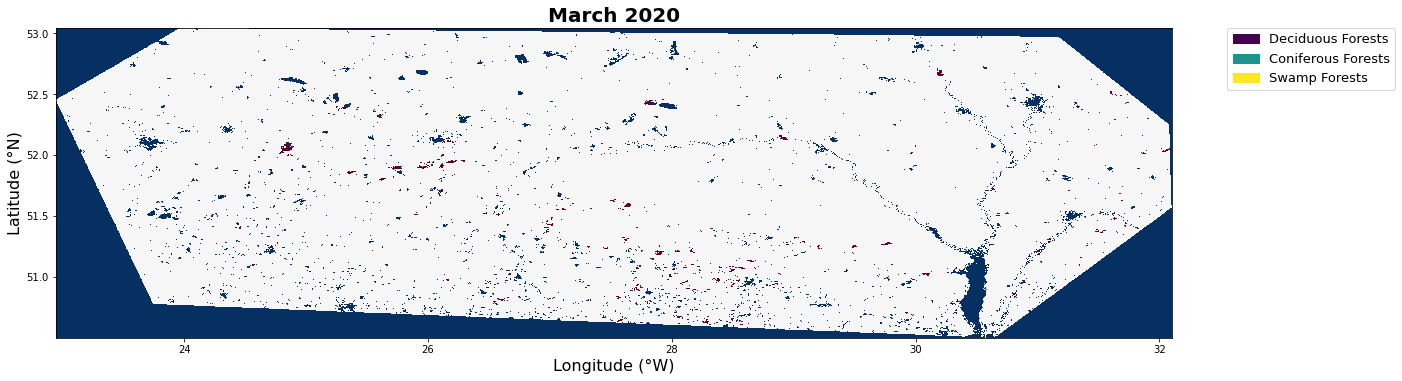

In [11]:
plt.close("all")
# Plot the data
fig, ax = plt.subplots(figsize=(20,12))
BurnMap_trimmed_xr.plot(ax=ax, add_colorbar=False);

tile = rasterio.open("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/practice_modis_data/BurnMap_trimmed_xr.tif")
im = ax.imshow(tile.read(1))
ep.draw_legend(im, titles=["Deciduous Forests", "Coniferous Forests", "Swamp Forests"])

# Finally, add a blue square to illustrate the training area
ax.set_title('Simple MODIS Burn Map: March 2020',fontsize=20,fontweight="bold");
ax.set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax.set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

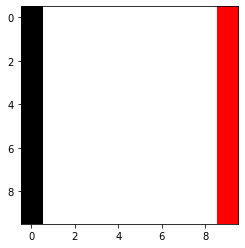

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

colors = [(0, 0, 0), (255, 255, 255), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
mat = np.indices((10,10))[1]
plt.imshow(mat, cmap=cm)
plt.show()

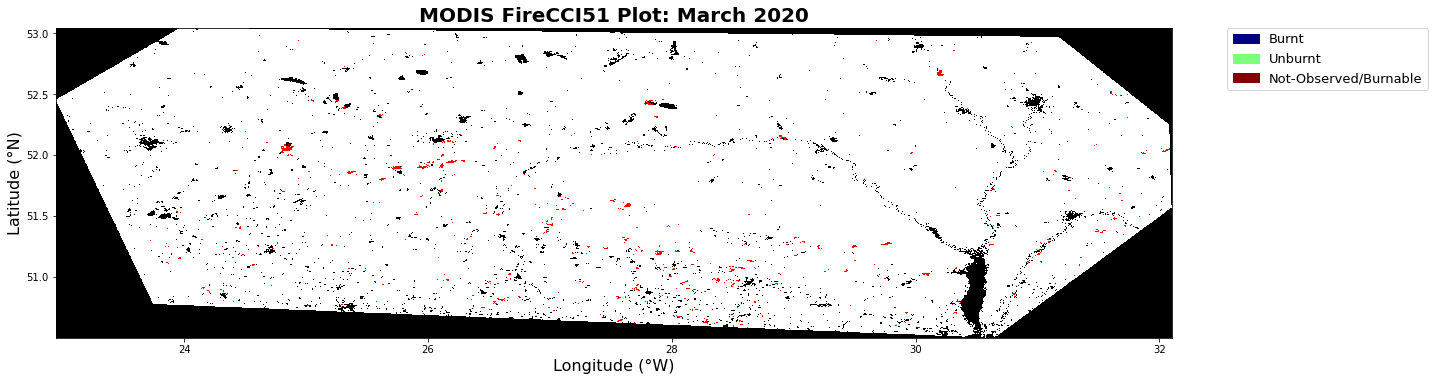

In [18]:
plt.close("all")
# Plot the data
fig, ax = plt.subplots(figsize=(20,12))
BurnMap_trimmed_xr.plot(ax=ax, add_colorbar=False,cmap=cm);
plt.set_cmap('jet')

tile = rasterio.open("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Lent/GTC/practice_modis_data/BurnMap_trimmed_xr.tif")
im = ax.imshow(tile.read(1))
ep.draw_legend(im, titles=["Burnt", "Unburnt", "Not-Observed/Burnable"])

# Finally, add a blue square to illustrate the training area
ax.set_title('MODIS FireCCI51 Plot: March 2020',fontsize=20,fontweight="bold");
ax.set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
ax.set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);